# OSM Establishments

In [53]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2021", 
                 password="5HOA&yn6$B", 
                 host="192.168.212.99", 
                 port=32771)

### Check OSM `ph_points`

In [5]:
ph_point = pd.read_sql('''
                        SELECT name, * FROM ph_point
                        LIMIT 100
                        ''', conn)
ph_point.columns

Index(['name', 'osm_id', 'access', 'addr:housename', 'addr:housenumber',
       'addr:interpolation', 'admin_level', 'aerialway', 'aeroway', 'amenity',
       'area', 'barrier', 'bicycle', 'brand', 'bridge', 'boundary', 'building',
       'capital', 'construction', 'covered', 'culvert', 'cutting',
       'denomination', 'disused', 'ele', 'embankment', 'foot',
       'generator:source', 'harbour', 'highway', 'historic', 'horse',
       'intermittent', 'junction', 'landuse', 'layer', 'leisure', 'lock',
       'man_made', 'military', 'motorcar', 'name', 'natural', 'office',
       'oneway', 'operator', 'place', 'population', 'power', 'power_source',
       'public_transport', 'railway', 'ref', 'religion', 'route', 'service',
       'shop', 'sport', 'surface', 'toll', 'tourism', 'tower:type', 'tunnel',
       'water', 'waterway', 'wetland', 'width', 'wood', 'z_order', 'way'],
      dtype='object')

In [37]:
provinces = ('Abra', 'Apayao', 'Benguet', 'Ifugao', 'Kalinga', 
            'Mountain Province','Metropolitan Manila', 'Ilocos Norte', 
            'Ilocos Sur', 'La Union', 'Pangasinan', 'Cagayan', 'Isabela', 
            'Nueva Vizcaya','Quirino','Aurora', 'Bataan', 'Bulacan', 
            'Nueva Ecija', 'Pampanga', 'Tarlac', 'Zambales', 'Batangas', 
            'Cavite', 'Laguna', 'Quezon', 'Rizal', 'Albay', 'Camarines Norte',
            'Camarines Sur','Sorsogon', 'Catanduanes', 'Marinduque', 
            'Occidental Mindoro', 'Oriental Mindoro','Romblon')

In [43]:
pd.read_sql(f'''
            SELECT * FROM gadm.ph_brgy
            WHERE name_1 in {provinces}
            ''', conn)

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,nl_name_2,gid_3,name_3,varname_3,nl_name_3,type_3,engtype_3,cc_3,hasc_3,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.1_1,Agtangao,None,None,Barangay,Village,None,None,0106000020E61000000100000001030000000100000043...
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.2_1,Angad,None,None,Barangay,Village,None,None,0106000020E61000000100000001030000000100000024...
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.3_1,Bañacao,None,None,Barangay,Village,None,None,0106000020E61000000100000001030000000100000016...
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.4_1,Bangbangar,None,None,Barangay,Village,None,None,0106000020E6100000010000000103000000010000000D...
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.5_1,Cabuloan,None,None,Barangay,Village,None,None,0106000020E61000000100000001030000000100000013...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19476,40085,PHL,Philippines,PHL.78_1,Zambales,None,PHL.78.14_1,Subic,None,PHL.78.14.12_1,Naugsol,None,None,Barangay,Village,None,None,0106000020E61000000100000001030000000100000018...
19477,40086,PHL,Philippines,PHL.78_1,Zambales,None,PHL.78.14_1,Subic,None,PHL.78.14.13_1,Pamatawan,None,None,Barangay,Village,None,None,0106000020E6100000010000000103000000010000001B...
19478,40087,PHL,Philippines,PHL.78_1,Zambales,None,PHL.78.14_1,Subic,None,PHL.78.14.14_1,San Isidro,None,None,Barangay,Village,None,None,0106000020E6100000010000000103000000010000000E...
19479,40088,PHL,Philippines,PHL.78_1,Zambales,None,PHL.78.14_1,Subic,None,PHL.78.14.15_1,Santo Tomas,None,None,Barangay,Village,None,None,0106000020E61000000100000001030000000100000011...


In [45]:
amenities = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, g.name_3, p.amenity,
                               st_area(st_transform(st_union(g.geom), 3123))/(1000^2) AS area, 
                               count(*) AS count_amenities
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.amenity IS NOT NULL
                        GROUP BY g.name_1, g.name_2, g.name_3, p.amenity
                        ORDER BY count_amenities DESC
                        """, conn)
amenities

,name_1,name_2,name_3,amenity,area,count_amenities
0,Metropolitan Manila,Makati City,Post Proper Northside,restaurant,3.239744,203
1,Metropolitan Manila,Makati City,San Lorenzo,bank,1.900705,148
2,Metropolitan Manila,Makati City,San Lorenzo,restaurant,1.900705,143
3,Laguna,Los Baños,Batong Malake,bench,9.775445,130
4,Metropolitan Manila,Makati City,Bel-Air,restaurant,1.689471,118
...,...,...,...,...,...,...
19376,Metropolitan Manila,Kalookan City,Barangay 107,hospital,0.049397,1
19377,Metropolitan Manila,Kalookan City,Barangay 107,police,0.049397,1
19378,Metropolitan Manila,Kalookan City,Barangay 108,atm,0.051051,1
19379,Metropolitan Manila,Kalookan City,Barangay 108,fast_food,0.051051,1


In [49]:
amenities['location'] = amenities['name_3'] + ", " + amenities['name_2'] + ", " + amenities['name_1']

In [51]:
pd.pivot_table(amenities, values='count_amenities', index='location', columns='amenity' ).fillna(0)

amenity,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,CheckPoint,Highway,Home Parking2,Kapampangan cuisine,"McKinley Hill, Taguig",...,waste_basket,waste_disposal,waste_transfer_station,water_point,waterwell,wayside_shrine,wellness,wheeler,wrecker_service,yes
location,,,,,,,,,,,,,,,,,,,,,
"Abaca, Bangui, Ilocos Norte",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abanao-Zandueta-Kayong-Chugum-Otek, Baguio City, Benguet",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abang, Lucban, Quezon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abangan Norte, Marilao, Bulacan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Abangan Sur, Marilao, Bulacan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"n.a, Infanta, Pangasinan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"n.a., Manila, Metropolitan Manila",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"n.a., Navotas, Metropolitan Manila",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
ph_shp = gpd.read_postgis('''
SELECT *
FROM gadm.ph_brgy
''', conn, geom_col='geom')
ph_shp.head()

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,nl_name_2,gid_3,name_3,varname_3,nl_name_3,type_3,engtype_3,cc_3,hasc_3,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.1_1,Agtangao,None,None,Barangay,Village,None,None,"MULTIPOLYGON (((120.63702 17.56270, 120.63690 ..."
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.2_1,Angad,None,None,Barangay,Village,None,None,"MULTIPOLYGON (((120.62151 17.57671, 120.62351 ..."
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.3_1,Bañacao,None,None,Barangay,Village,None,None,"MULTIPOLYGON (((120.59573 17.60569, 120.58296 ..."
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.4_1,Bangbangar,None,None,Barangay,Village,None,None,"MULTIPOLYGON (((120.60975 17.60699, 120.60423 ..."
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.5_1,Cabuloan,None,None,Barangay,Village,None,None,"MULTIPOLYGON (((120.61269 17.59633, 120.61466 ..."


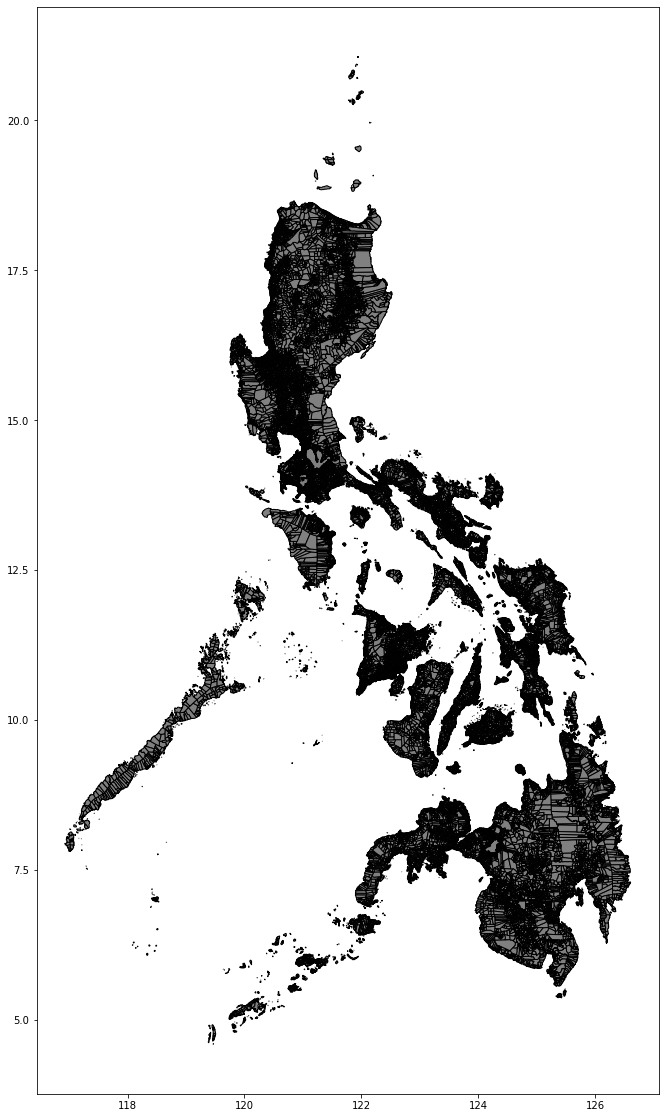

In [58]:
ax = ph_shp.plot(figsize=(20,20), color='gray', edgecolor='black')